In [31]:
import pandas as pd
import sqlite3
import json
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from path_util import data_path
from count_contributions import contributions_by_user

In [2]:
db_path = data_path / "data_bases" / "all_occupations.db"

con = sqlite3.connect(db_path)

df_all = pd.read_sql('SELECT occ_code, occ_group, occ_title, lenient_links, lenient_revs, lenient_lengths, women, white, african_american, asian, hispanic  FROM occupations', con)

df = df_all # make sure there is a copy

print("The number of entries:", len(df))
df.head(4)

The number of entries: 1395


,occ_code,occ_group,occ_title,lenient_links,lenient_revs,lenient_lengths,women,white,african_american,asian,hispanic
0,11-0000,major,Management Occupations,"[[""Certified Financial Manager"", ""http://en.wi...","{""Certified Financial Manager"": [{""revid"": 581...","{""Certified Financial Manager"": 2611, ""Marketi...",0.409,0.822,0.086,0.065,0.111
1,11-1000,minor,Top Executives,"[[""General manager"", ""http://en.wikipedia.org/...","{""General manager"": [{""revid"": 749862417, ""use...","{""General manager"": 7116, ""Chief executive off...",null,null,null,null,null
2,11-1010,broad,Chief Executives,"[[""Chief executive officer"", ""http://en.wikipe...","{""Chief executive officer"": [{""revid"": 6437689...","{""Chief executive officer"": 17489}",0.291,0.857,0.059,0.068,0.074
3,11-1011,detailed,Chief Executives,"[[""Chief executive officer"", ""http://en.wikipe...","{""Chief executive officer"": [{""revid"": 6437689...","{""Chief executive officer"": 17489}",0.291,0.857,0.059,0.068,0.074


[1.0, 0.128, 0.694, 0.545]


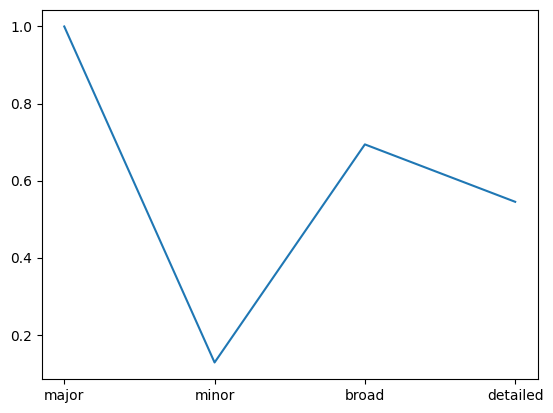

In [3]:
pct_major = round((len(df.loc[(df['occ_group'] == "major") & (df['women'] != "null")]) / 22), 3)
pct_minor = round((len(df.loc[(df['occ_group'] == "minor") & (df['women'] != "null")]) / 94), 3)
pct_broad = round((len(df.loc[(df['occ_group'] == "broad") & (df['women'] != "null")]) / 448), 3)
pct_detailed = round((len(df.loc[(df['occ_group'] == "detailed") & (df['women'] != "null")]) / 831), 3)

values = [pct_major, pct_minor, pct_broad, pct_detailed]
descriptions = ["major", "minor", "broad", "detailed"]

print(values)
plt.plot(descriptions, values)

## Deleting nulls, parsing floats

In [4]:
df = df.loc[df['women'] != "null"] # delete nulls

# fix parsing as float and rounding
for col in ["women", "white", "african_american", "asian", "hispanic"]:
    df[col] = df[col].astype(float)
    df[col] = df[col].apply(lambda x: round(x, 3))

C:\Users\leond\AppData\Local\Temp\ipykernel_18616\3113283168.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float)
C:\Users\leond\AppData\Local\Temp\ipykernel_18616\3113283168.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: round(x, 3))


In [5]:
df = df.dropna()
df

,occ_code,occ_group,occ_title,lenient_links,lenient_revs,lenient_lengths,women,white,african_american,asian,hispanic
0,11-0000,major,Management Occupations,"[[""Certified Financial Manager"", ""http://en.wi...","{""Certified Financial Manager"": [{""revid"": 581...","{""Certified Financial Manager"": 2611, ""Marketi...",0.409,0.822,0.086,0.065,0.111
2,11-1010,broad,Chief Executives,"[[""Chief executive officer"", ""http://en.wikipe...","{""Chief executive officer"": [{""revid"": 6437689...","{""Chief executive officer"": 17489}",0.291,0.857,0.059,0.068,0.074
3,11-1011,detailed,Chief Executives,"[[""Chief executive officer"", ""http://en.wikipe...","{""Chief executive officer"": [{""revid"": 6437689...","{""Chief executive officer"": 17489}",0.291,0.857,0.059,0.068,0.074
4,11-1020,broad,General and Operations Managers,"[[""General manager"", ""http://en.wikipedia.org/...","{""General manager"": [{""revid"": 749862417, ""use...","{""General manager"": 7116, ""Operations manageme...",0.364,0.827,0.093,0.046,0.103
5,11-1021,detailed,General and Operations Managers,"[[""General manager"", ""http://en.wikipedia.org/...","{""General manager"": [{""revid"": 749862417, ""use...","{""General manager"": 7116, ""Operations manageme...",0.364,0.827,0.093,0.046,0.103
...,...,...,...,...,...,...,...,...,...,...,...
1383,53-7064,detailed,"Packers and Packagers, Hand",[],{},{},0.521,0.679,0.191,0.085,0.380
1384,53-7065,detailed,Stockers and Order Fillers,[],{},{},0.371,0.695,0.213,0.038,0.204
1389,53-7080,broad,Refuse and Recyclable Material Collectors,[],{},{},0.121,0.789,0.186,0.000,0.277
1390,53-7081,detailed,Refuse and Recyclable Material Collectors,[],{},{},0.121,0.789,0.186,0.000,0.277


In [7]:
df_major = df.loc[df['occ_group'] == "major"]
df_major

,occ_code,occ_group,occ_title,lenient_links,lenient_revs,lenient_lengths,women,white,african_american,asian,hispanic
0,11-0000,major,Management Occupations,"[[""Certified Financial Manager"", ""http://en.wi...","{""Certified Financial Manager"": [{""revid"": 581...","{""Certified Financial Manager"": 2611, ""Marketi...",0.409,0.822,0.086,0.065,0.111
73,13-0000,major,Business and Financial Operations Occupations,"[[""Loan officer"", ""http://en.wikipedia.org/?cu...","{""Loan officer"": [{""revid"": 492957605, ""user"":...","{""Loan officer"": 10956, ""Financial adviser"": 2...",0.548,0.780,0.105,0.086,0.103
129,15-0000,major,Computer and Mathematical Occupations,"[[""Information scientist"", ""http://en.wikipedi...","{""Information scientist"": [{""revid"": 329917919...","{""Information scientist"": 2757, ""Software deve...",0.262,0.654,0.085,0.233,0.083
165,17-0000,major,Architecture and Engineering Occupations,"[[""Engineer"", ""http://en.wikipedia.org/?curid=...","{""Engineer"": [{""revid"": 194559099, ""user"": ""68...","{""Engineer"": 46284, ""Technologist"": 1755, ""Lan...",0.174,0.770,0.058,0.146,0.099
226,19-0000,major,"Life, Physical, and Social Science Occupations","[[""Conservation scientist"", ""http://en.wikiped...","{""Conservation scientist"": [{""revid"": 93806143...","{""Conservation scientist"": 29473, ""Biochemist""...",0.474,0.746,0.074,0.152,0.083
305,21-0000,major,Community and Social Service Occupations,"[[""Community health worker"", ""http://en.wikipe...","{""Community health worker"": [{""revid"": 2807264...","{""Community health worker"": 37444, ""Genetic co...",0.675,0.729,0.197,0.038,0.125
331,23-0000,major,Legal Occupations,"[[""Lawyer"", ""http://en.wikipedia.org/?curid=17...","{""Lawyer"": [{""revid"": 53322369, ""user"": ""Graem...","{""Lawyer"": 94101, ""Magistrate"": 40682, ""Law cl...",0.535,0.840,0.081,0.048,0.104
346,25-0000,major,Educational Instruction and Library Occupations,"[[""Library technician"", ""http://en.wikipedia.o...","{""Library technician"": [{""revid"": 230002599, ""...","{""Library technician"": 6529, ""Teacher"": 63427,...",0.737,0.815,0.099,0.056,0.108
443,27-0000,major,"Arts, Design, Entertainment, Sports, and Media...","[[""Handicraft"", ""http://en.wikipedia.org/?curi...","{""Handicraft"": [{""revid"": 90415092, ""user"": ""M...","{""Handicraft"": 15364, ""Designer"": 3819, ""Autho...",0.500,0.829,0.082,0.057,0.111
505,29-0000,major,Healthcare Practitioners and Technical Occupat...,"[[""Veterinarian"", ""http://en.wikipedia.org/?cu...","{""Veterinarian"": [{""revid"": 355129330, ""user"":...","{""Veterinarian"": 50710, ""Psychiatrist"": 14239,...",0.743,0.756,0.120,0.095,0.094


In [37]:
def amount_detailed(df_all, df_major):
    amount_of_detailed = []
    for code in df_major["occ_code"].tolist():
        sub_df = df_all[df_all['occ_code'].str.contains(str(code)[0:2] + "-")]
        df_sub_detailed = sub_df.loc[(sub_df["occ_group"] == "detailed")]
        amount_of_detailed.append(len(df_sub_detailed))
        
    articles_per_detailed = []
    for idx, lst in enumerate(df_major["lenient_links"].tolist()):
        articles_per_detailed.append((len(json.loads(lst))/amount_of_detailed[idx]))  
        
    return articles_per_detailed

def avg_unique_users_page_lengths(df_major):
    unique_users = []
    page_lengths = []
    
    for idx, links_list in enumerate(df_major["lenient_links"].tolist()):
        revisions = json.loads(df_major.iloc[idx]["lenient_revs"])
        
        for link in links_list:
            link_name = link[0]
            
            # continue here
            
            
            
    avg_unique_users = []
    avg_page_lengths = []


In [36]:
articles_per_detailed = amount_detailed(df, df_major)

if "art_per_detailed" not in df_major:
    df_major.insert(4, "art_per_detailed", articles_per_detailed)

df_major.head(3)

,occ_code,occ_group,occ_title,lenient_links,total_detailed,art_per_detailed,lenient_revs,lenient_lengths,women,white,african_american,asian,hispanic
0,11-0000,major,Management Occupations,"[[""Certified Financial Manager"", ""http://en.wi...",23,0.782609,"{""Certified Financial Manager"": [{""revid"": 581...","{""Certified Financial Manager"": 2611, ""Marketi...",0.409,0.822,0.086,0.065,0.111
73,13-0000,major,Business and Financial Operations Occupations,"[[""Loan officer"", ""http://en.wikipedia.org/?cu...",21,0.476190,"{""Loan officer"": [{""revid"": 492957605, ""user"":...","{""Loan officer"": 10956, ""Financial adviser"": 2...",0.548,0.780,0.105,0.086,0.103
129,15-0000,major,Computer and Mathematical Occupations,"[[""Information scientist"", ""http://en.wikipedi...",13,1.538462,"{""Information scientist"": [{""revid"": 329917919...","{""Information scientist"": 2757, ""Software deve...",0.262,0.654,0.085,0.233,0.083


In [27]:
def viz_two_axes(df, target_variable, second_metric):
    df_viz = df.sort_values(by = [second_metric])
    df_viz.plot(kind = "bar", x = "occ_code", y = [target_variable, second_metric], 
                secondary_y = [second_metric], rot = 0)
    plt.show()
    
def viz_scatterplot_correlation(df, target_variable, second_metric):
    articles = df[second_metric].tolist()
    target = df[target_variable].tolist()
    
    corr, _ = pearsonr(target, articles)
    print('Pearsons correlation: %.3f' % corr)
    
    plt.scatter(articles, target)
    plt.show()

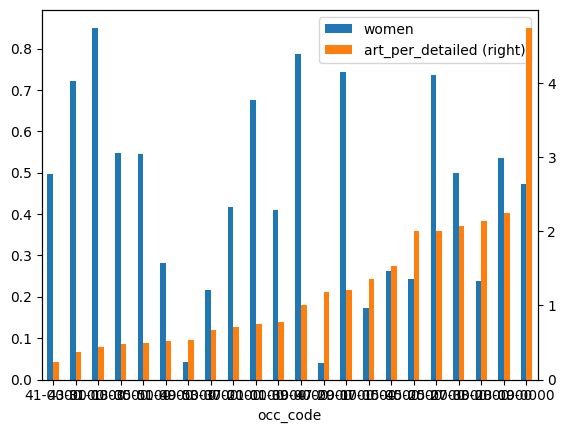

Pearsons correlation: -0.070


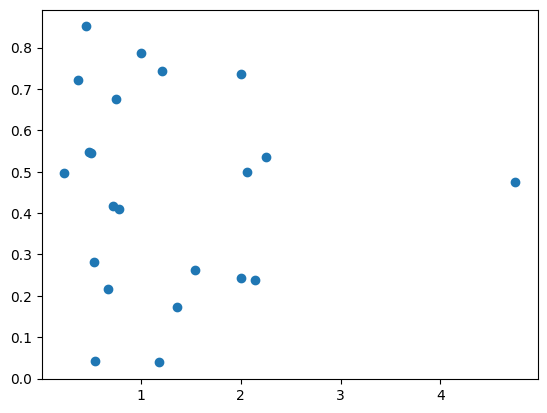

In [28]:
viz_two_axes(df_major, "women", "art_per_detailed")

viz_scatterplot_correlation(df_major, "women", "art_per_detailed")
